In [20]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

In [21]:
df = pd.read_csv("Sales_data.csv") # Initialize DataFrame

df = df[["City", "Date", "gross income", "Product line", "Total", "cogs", "Quantity"]] # Remove unnecessary columns

df = df.rename(columns={"cogs" : "cost price"}) # Rename column for clarity

df.dropna(subset=["Date"], inplace=True) # Delete rows with missing dates

df.drop_duplicates(subset=None, keep="first", inplace=True) # Check for and remove duplicate rows if present

df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y") # Ensure Date column is in DateTime format

df["Date"] =  df["Date"].sort_values(ascending=True).values # Sort dates in ascending order

def round_off(number):
    return round(number, 2)

df["gross income"] = df["gross income"].apply(round_off) # Round off gross income values to 2 decimals
df["Total"] = df["Total"].apply(round_off)

# Breakdown Amount of Sales per City
city_groups = df.groupby("City").count()
print(city_groups["gross income"]) # Print the amount of sales per city

df.drop_duplicates(subset="Date", keep="first", inplace=True) # Remove duplicate dates

City
Mandalay     332
Naypyitaw    328
Yangon       340
Name: gross income, dtype: int64


In [22]:
df.head()

,City,Date,gross income,Product line,Total,cost price,Quantity
0,Yangon,2019-01-01,26.14,Health and beauty,548.97,522.83,7
12,Yangon,2019-01-02,11.74,Electronic accessories,246.49,234.75,5
20,Naypyitaw,2019-01-03,21.51,Electronic accessories,451.71,430.20,5
28,Mandalay,2019-01-04,22.09,Food and beverages,463.89,441.80,5
34,Naypyitaw,2019-01-05,19.88,Food and beverages,417.56,397.68,4


In [23]:
# Plot Monthly Sales Trends

# January Seasonality Trend
jan_sales_trends_fig = px.line(df, x=df["Date"][:31], y=df["gross income"][:31], title="January Seasonality Trend")
jan_sales_trends_fig.update_layout(
    xaxis_title = "Date (Day)",
    yaxis_title = "Gross Income"
)
jan_sales_trends_fig.show()

# Febraury Seasonality Trend
feb = df[df["Date"].dt.month == 2]
feb_sales_trends_fig = px.line(df, x=feb["Date"], y=df["gross income"][:len(feb)], title="February Seasonality Trend")
feb_sales_trends_fig.update_layout(
    xaxis_title = "Date (Day)",
    yaxis_title = "Gross Income"
)
feb_sales_trends_fig.show()

# March Seasonality Trend
mar = df[df["Date"].dt.month == 3]
mar_sales_trends_fig = px.line(df, x=mar["Date"], y=df["gross income"][:len(mar)], title="March Seasonality Trend")
mar_sales_trends_fig.update_layout(
    xaxis_title = "Date (Day)",
    yaxis_title = "Gross Income"
)
mar_sales_trends_fig.show()

In [24]:
sales_per_country_figure = px.bar(df, x="City", y="gross income", title="Total Sales per city") # Bar plot for total sales per city

sales_per_country_figure.show()

In [25]:
product_sales = df.groupby("Product line").count() # Group sales by the products lines

top_5_product_sales = product_sales["gross income"].sort_values(ascending=False)[:5]

print(f"Top 5 highest selling products: \n\n{top_5_product_sales}")

Top 5 highest selling products: 

Product line
Home and lifestyle        19
Electronic accessories    17
Fashion accessories       16
Food and beverages        14
Sports and travel         13
Name: gross income, dtype: int64


In [26]:
df["Profit Margins"] = ((df["Total"] - df["cost price"]) / df["Total"]) * 100 # Create Profit Margins column
df["Profit Margins"] = df["Profit Margins"].apply(round_off)

print(df["Profit Margins"].unique()) # Display unique profit margins

[4.76 4.77]


## SARIMA Model

In [27]:
# Split data into train and test
train_test_split = int(0.75 * len(df))
train_data = df[:train_test_split]
test_data = df[train_test_split:]

In [28]:
def adf_test(timeseries):
    # Tests if timeseries is statioary
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    
# Difference data
train_data["gross income"] = train_data["gross income"].diff()
test_data["gross income"] = test_data["gross income"].diff()

adf_test(train_data["gross income"].dropna())

ADF Statistic: -4.7095940738445945
p-value: 8.072903063375417e-05


C:\Users\LESEGO\AppData\Local\Temp\ipykernel_10424\3412497417.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\LESEGO\AppData\Local\Temp\ipykernel_10424\3412497417.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 1200x600 with 0 Axes>

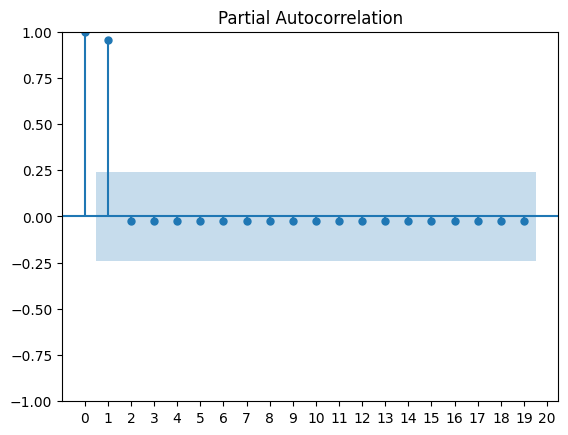

In [29]:
# Determine p variable with Partial Autocorrelation Plot
plt.figure(figsize=(12, 6))
plot_pacf(train_data["Date"])
plt.xticks(np.arange(0,21, 1))
plt.show() # p = 2

In [30]:
# Determine d variable by observing trend of data
overall_trend_fig = px.line(train_data, x="Date", y="gross income", title="Overall Trend of gross income")
overall_trend_fig.show() # d = 1

In [49]:
arima_model = ARIMA(df["gross income"], order=(2, 1, 1)) # Create ARIMA model
arima_model_fitted = arima_model.fit() # Fit the model

print(arima_model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:           gross income   No. Observations:                   89
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -343.462
Date:                Thu, 10 Oct 2024   AIC                            694.925
Time:                        14:20:17   BIC                            704.834
Sample:                             0   HQIC                           698.917
                                 - 89                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1817      0.110      1.645      0.100      -0.035       0.398
ar.L2         -0.2223      0.123     -1.805      0.071      -0.464       0.019
ma.L1         -0.9789      0.053    -18.369      0.0

C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [94]:
arima_forecast = arima_model_fitted.get_forecast(steps=10) # ARIMA Forecast
arima_forecast_values = arima_model_fitted.forecast(steps=10).values

# Get confidence interval and forecast mean
forecast_mean = arima_forecast.predicted_mean
confidence_intervals = arima_forecast.conf_int()

# Get lower and upper confidence intervals
lower_limits = confidence_intervals.iloc[:, 0]
upper_limits = confidence_intervals.iloc[:, 1]

C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\LESEGO\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



[]

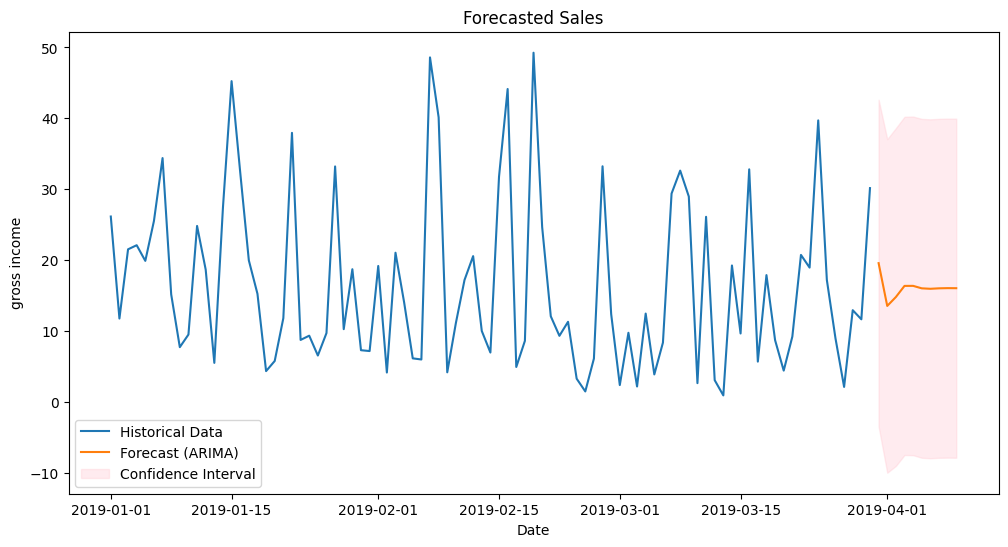

In [96]:
# Plot Forecast with Confidence Interval
forecast_index = pd.date_range(df["Date"].iloc[-1], periods=10 + 1, freq='D')[1:]
plt.figure(figsize=(12, 6))
sns.lineplot(x=df["Date"], y=df["gross income"], label="Historical Data")
sns.lineplot(x=forecast_index, y=arima_forecast_values, label="Forecast (ARIMA)")
plt.fill_between(forecast_index, lower_limits, upper_limits, color='pink', alpha=0.3, label='Confidence Interval')
plt.title("Forecasted Sales")
plt.legend()
plt.plot()

In [101]:
# Create new ARIMA DataFrame
arima_df = pd.DataFrame(forecast_index)
arima_df.rename(columns={0 : "Date"}, inplace=True)
arima_df["ARIMA Forecast"] = arima_forecast_values # Add arima forecast values

# Add DataFrames to csv files
df.to_csv("Sales_processed_data.csv", index=False)
arima_df.to_csv("ARIMA_data.csv") 